<a href="https://colab.research.google.com/github/mbuguajackson/Data-Science-with-Python/blob/main/test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# id_classifier.py
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os

In [2]:
from pickle import TRUE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_dir = "/content/drive/My Drive/Colab Notebooks/ID Recognition"
val_dir = "/content/drive/My Drive/Colab Notebooks/ID Recognition"


In [4]:
# Data generator
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    class_mode='binary'
)

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# Add classifier head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_gen, validation_data=val_gen, epochs=5)

Found 28 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6071 - loss: 0.6989

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.6071 - loss: 0.6989 - val_accuracy: 0.6429 - val_loss: 0.6008
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6429 - loss: 0.6008 - val_accuracy: 0.8214 - val_loss: 0.4855
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8214 - loss: 0.4855 - val_accuracy: 0.8571 - val_loss: 0.4539
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8571 - loss: 0.4539 - val_accuracy: 0.8929 - val_loss: 0.3959
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8929 - loss: 0.3959 - val_accuracy: 0.8571 - val_loss: 0.3523


Saving id4.jpg to id4.jpg


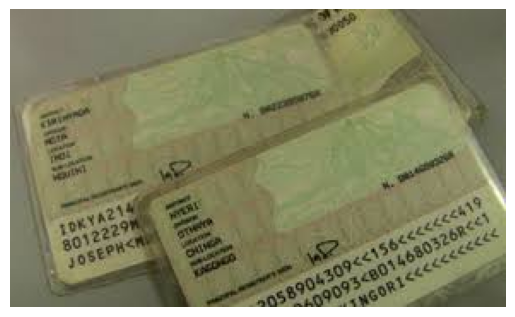

In [5]:
from google.colab import files
uploaded = files.upload()

from PIL import Image
import matplotlib.pyplot as plt

# Get the uploaded filename
filename = next(iter(uploaded))  # gets the first (and likely only) uploaded file

# Load and display the image
image = Image.open(filename)
plt.imshow(image)
plt.axis('off')
plt.show()


In [6]:
import numpy as np

# Ensure image is RGB
img = image.convert("RGB").resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: ID")
else:
    print("Prediction: Not ID")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: ID


In [7]:
!pip install fastapi uvicorn pyngrok --quiet

In [11]:
# Load the trained model
model.save("id_classifier.h5")
model = tf.keras.models.load_model("id_classifier.h5")

In [12]:
%%writefile app.py
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Load the trained model
model = tf.keras.models.load_model("id_classifier.h5")

app = FastAPI()

@app.post("/predict")
async def predict_image(file: UploadFile = File(...)):
    contents = await file.read()
    image = Image.open(io.BytesIO(contents)).convert("RGB").resize((224, 224))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "ID" if prediction[0][0] > 0.5 else "Not ID"

    return JSONResponse(content={"prediction": label})


Overwriting app.py


In [13]:
from pyngrok import ngrok

# Add your token here
ngrok.set_auth_token("2z2aEg1f662KNOsKCTogbvO3osO_2aKxK59QEKimDMxEwdKLa")

# Open a tunnel on port 8000
public_url = ngrok.connect(8000)
print("Your public API URL:", public_url)

# Launch FastAPI server
!uvicorn app:app --host 0.0.0.0 --port 8000


Your public API URL: NgrokTunnel: "https://4c7a-34-169-94-199.ngrok-free.app" -> "http://localhost:8000"
2025-06-26 10:06:36.003404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750932396.027649   37504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750932396.035335   37504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 10:06:42.326690: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO:     Started server process [37504]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running 